# Run the FastScape landscape evolution model

UPDATE WITH INFO ABOUT FASTSCAPE & LEMS HERE

In [1]:
import numpy as np
import xarray as xr
import xsimlab as xs
import fastscape

## Import the basic model

INFO HERE

In [2]:
from fastscape.models import basic_model

## Info from Fastscape

This model simulates the long-term evolution of topographic surface elevation (hereafter noted $h$) on a 2D regular grid. The local rate of elevation change, $\partial h/\partial t$, is determined by the balance between uplift (uniform in space and time) $U$ and erosion $E$.

$$\frac{\partial h}{\partial t} = U - E$$

Total erosion $E$ is the combined effect of the erosion of (bedrock) river channels, noted $E_r$, and erosion- transport on hillslopes, noted $E_d$

$$E = E_r + E_d$$

Erosion of river channels is given by the stream power law:

$$E_r = K_r A^m (\nabla h)^n$$

where $A$ is the drainage area and $K$, $m$ and $n$ are parameters.

Erosion on hillslopes is given by a linear diffusion law:

$$E_d = K_d \nabla^2 h$$


``xarray-simlab`` is a modular framework, where model inputs are automatically retrieved from model components. ``basic_model`` is a ``xsimlab.Model`` object that contains a bunch of components. Just typing ``basic_model`` shows the ordered list of components as well as all model inputs (parameters), grouped by the component to which they belong:

## UPDATE ABOUT VISUALIZING MODEL

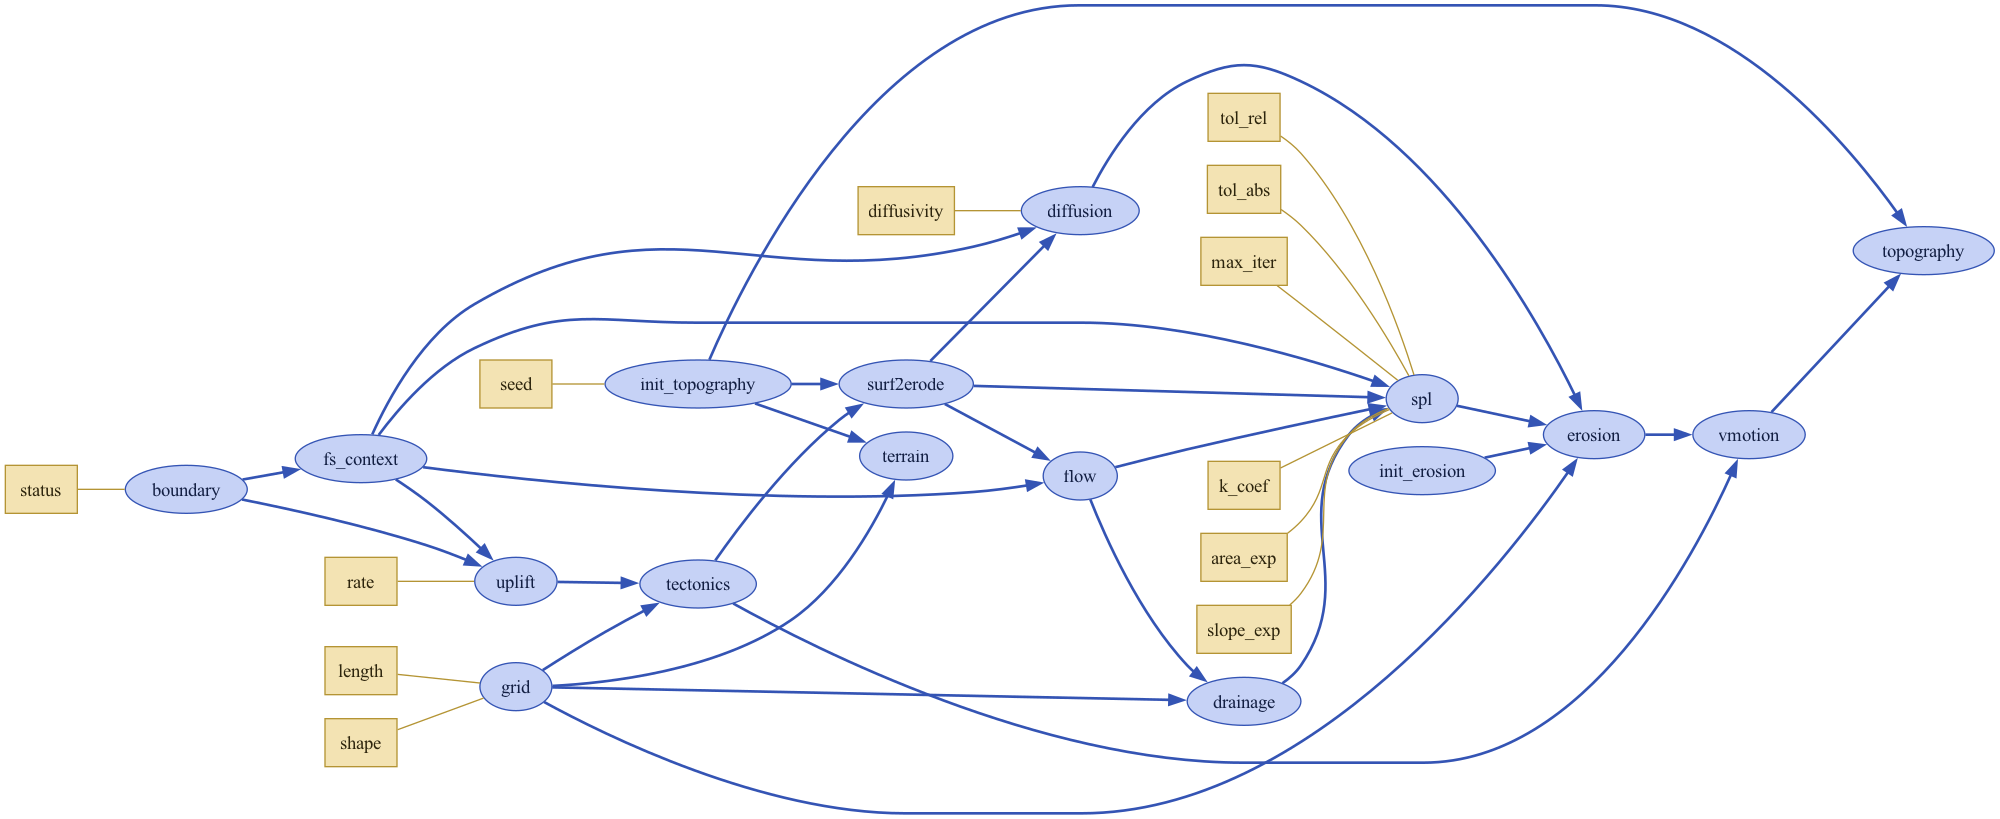

In [3]:
basic_model.visualize(show_inputs=True)

In [9]:
basic_model.flow

<SingleFlowRouter 'flow' (xsimlab process)>
Variables:
    shape            [in] <--- grid.shape
    elevation        [in] <--- surf2erode.elevation
    fs_context       [in] <--- fs_context.context
    stack           [out] ('node',) DFS ordered grid node indices
    nb_receivers    [out] ('node',) number of flow receivers
    receivers       [out] ('node',) or ('node', 'nb_rec_max') flow ...
    lengths         [out] ('node',) or ('node', 'nb_rec_max') out f...
    weights         [out] ('node',) or ('node', 'nb_rec_max') flow ...
    nb_donors       [out] ('node',) number of flow donors
    donors          [out] ('node', 'nb_don_max') flow donors node i...
    basin           [out] ('y', 'x') river catchments
    lake_depth      [out] ('y', 'x') lake depth
    slope           [out] ('node',) out flow path slope
Simulation stages:
    initialize
    run_step

## Create a model setup

We create a simulation setup using the `create_setup` function.

In [4]:
nx = 101
ny = 101

in_ds = xs.create_setup(
    model=basic_model,
    clocks={
        'time': np.linspace(0., 1e6, 101),
        'out': np.linspace(0., 1e6, 21)
    },
    master_clock='time',
    input_vars={
        'grid__shape': [101, 101],
        'grid__length': [1e4, 1e4],
        'boundary__status': ['looped', 'looped', 'fixed_value', 'fixed_value'],
        'uplift__rate': 1e-3,
        'spl': {'k_coef': 1e-4, 'area_exp': 0.4, 'slope_exp': 1.},
        'diffusion__diffusivity': 1e-1
    },
    output_vars={
        'topography__elevation': 'out',
        'drainage__area': 'out',
        'flow__basin': 'out',
        'spl__chi': None
    }
)

/opt/homebrew/anaconda3/envs/fastscape-demo/lib/python3.13/site-packages/xsimlab/xr_accessor.py:229: FutureWarning: variable 'time' with name matching its dimension will not be automatically converted into an `IndexVariable` object in the future.
  xr_var = as_variable(data, name=dim)
/opt/homebrew/anaconda3/envs/fastscape-demo/lib/python3.13/site-packages/xsimlab/xr_accessor.py:229: FutureWarning: variable 'out' with name matching its dimension will not be automatically converted into an `IndexVariable` object in the future.
  xr_var = as_variable(data, name=dim)


## UPDATE THIS SECTION WITH DESCRIPTION OF MODEL SET UP

SPL IS STREAM POWER LAW

Some explanation about the arguments of `create_setup` and the values given above:

- we specify the model we want to use, here `basic_model`,
- we specify values for clock coordinates (i.e., time coordinates),
- among these coordinates, we specify the master clock, i.e., the coordinate that will be used to
  set the time steps,
- we set values for model inputs (may be grouped by process in the model),
- we set the model variables and the clock coordinate for which we want to take snapshots during a simulation (`None` means that only one snapshot will be taken at the end of the simulation).
  
Here above, we define a 'time' coordinate and another coordinate 'out' with much larger but aligned
time steps (the values are in years). 'time' will be used for the simulation time steps and 'out' will be used to take just a few, evenly-spaced snapshots of
a few variables like topographic elevation, drainage area and catchments. We also save the $\chi$ values at the end of the simulation.

The initial conditions consist here of a nearly flat topographic surface with small random perturbations. Boundaries are periodic on the left and right borders and fixed on the top and bottom borders.

In [ ]:
in_ds.spl__k_coef

## Run the model

We run the model simply by calling `in_ds.xsimlab.run()`, which returns a new Dataset with both the inputs and the outputs. 

In [5]:
out_ds = in_ds.xsimlab.run(model=basic_model)

## Analyse, plot and save the results 

SOMETHING ABOUT how model did stuff in the background
``hvplot`` (built on top of ``holoviews`` and ``bokeh``) to create interactive figures.

In [9]:
import matplotlib.pyplot as plt
import hvplot.xarray
%matplotlib inline

hvplot.output(widget_location='bottom')

In [35]:
dem = out_ds.topography__elevation.hvplot.image(x='x',y='y',
                                                cmap='inferno',
                                                groupby='out',
                                                invert=True,
                                                width=500,      
                                                height=333)
swath = out_ds.mean(dim='x').topography__elevation.hvplot(groupby='out',
                                                          c='black',
                                                          xlabel='', ylabel='Elevation (m)',
                                                          title='Basic Model',
                                                          ylim=(0, 300), 
                                                          width=500, 
                                                          height=160
                                                          )


basicm_plot = (swath + dem).cols(1)
basicm_plot

:Layout
   .DynamicMap.I  :DynamicMap   [out]
      :Curve   [y]   (topography__elevation)
   .DynamicMap.II :DynamicMap   [out]
      :Image   [x,y]   (topography__elevation)

## DROP DIFFUSION

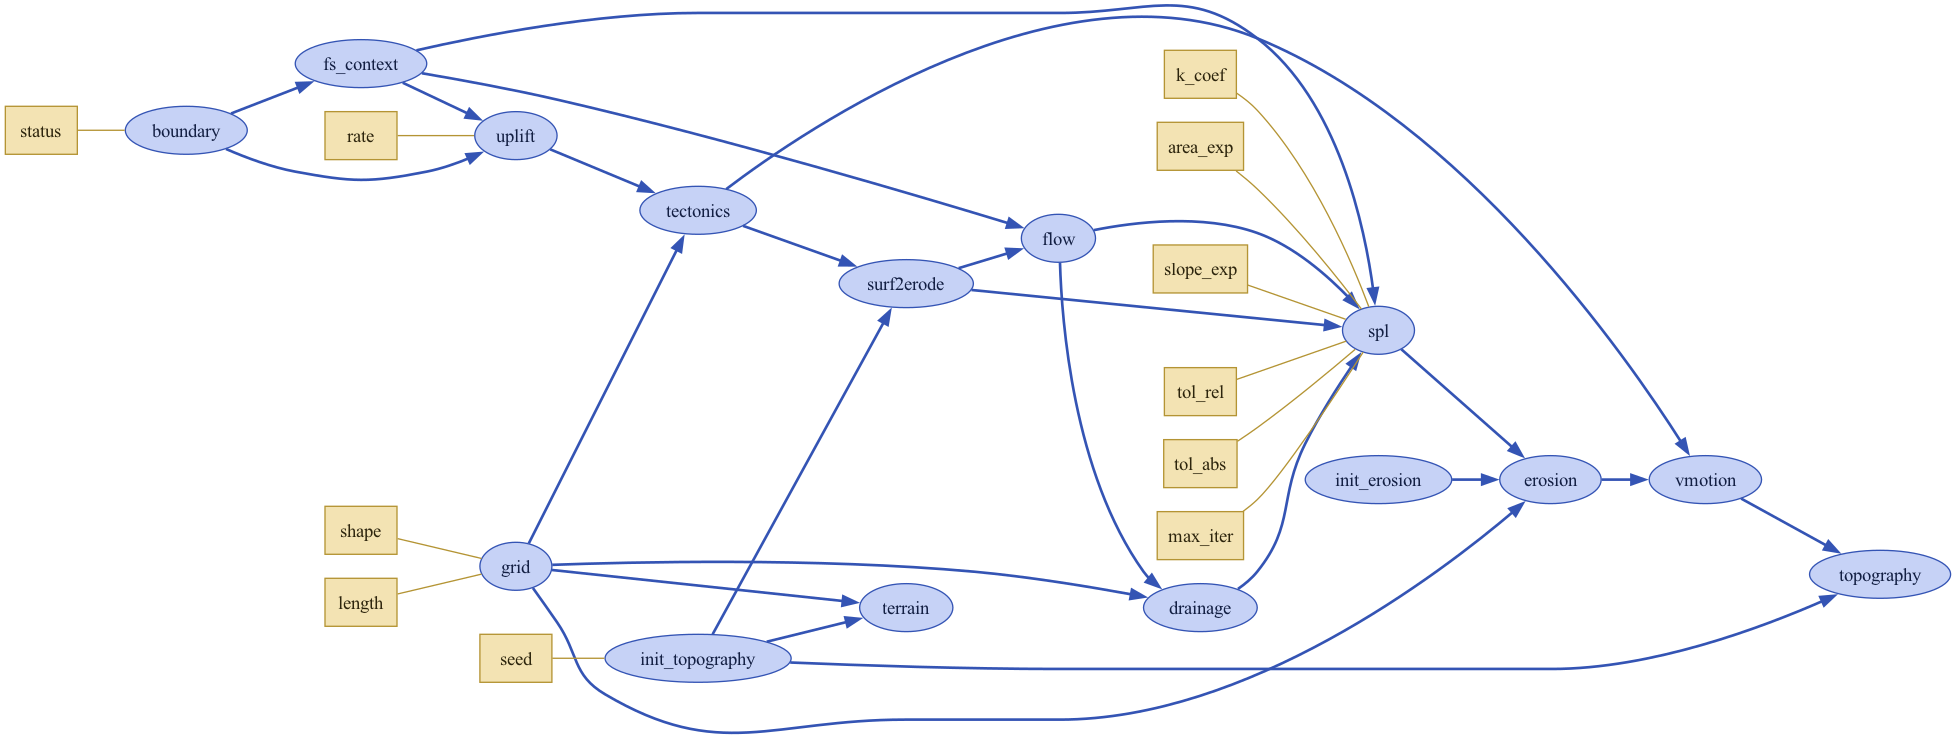

In [27]:
no_diff_model = basic_model.drop_processes('d')

no_diff_model.visualize(show_inputs=True)

In [28]:
in_nd = xs.create_setup(
    model=no_diff_model,
    clocks={
        'time': np.linspace(0., 1e6, 101),
        'out': np.linspace(0., 1e6, 21)
    },
    master_clock='time',
    input_vars={
        'grid__shape': [101, 101],
        'grid__length': [1e4, 1e4],
        'boundary__status': ['looped', 'looped', 'fixed_value', 'fixed_value'],
        'uplift__rate': 1e-3,
        'spl': {'k_coef': 1e-4, 'area_exp': 0.4, 'slope_exp': 1.},
    
    },
    output_vars={
        'topography__elevation': 'out',
        'drainage__area': 'out',
        'flow__basin': 'out',
        'spl__chi': None
    }
)

/opt/homebrew/anaconda3/envs/fastscape-demo/lib/python3.13/site-packages/xsimlab/xr_accessor.py:229: FutureWarning: variable 'time' with name matching its dimension will not be automatically converted into an `IndexVariable` object in the future.
  xr_var = as_variable(data, name=dim)
/opt/homebrew/anaconda3/envs/fastscape-demo/lib/python3.13/site-packages/xsimlab/xr_accessor.py:229: FutureWarning: variable 'out' with name matching its dimension will not be automatically converted into an `IndexVariable` object in the future.
  xr_var = as_variable(data, name=dim)


In [29]:
out_nd = in_nd.xsimlab.run(model=no_diff_model)

In [30]:
dem_nd = out_nd.topography__elevation.hvplot.image(x='x',y='y',
                                          cmap='inferno',
                                          groupby='out',
                                          invert=True,
                                          width=500,      
                                          height=333)
swath_nd = out_nd.mean(dim='x').topography__elevation.hvplot(groupby='out',
                                                          c='black',
                                                          xlabel='', ylabel='Elevation (m)',
                                                          title='No Diffusion',
                                                          ylim=(0, 300), 
                                                          width=500, 
                                                          height=160
                                                          )


nd_plot = (swath_nd + dem_nd).cols(1)
nd_plot

:Layout
   .DynamicMap.I  :DynamicMap   [out]
      :Curve   [y]   (topography__elevation)
   .DynamicMap.II :DynamicMap   [out]
      :Image   [x,y]   (topography__elevation)

## Look at all together

In [31]:
all_plt = (swath + swath_nd + dem + dem_nd).cols(2)
all_plt

:Layout
   .DynamicMap.I   :DynamicMap   [out]
      :Curve   [y]   (topography__elevation)
   .DynamicMap.II  :DynamicMap   [out]
      :Curve   [y]   (topography__elevation)
   .DynamicMap.III :DynamicMap   [out]
      :Image   [x,y]   (topography__elevation)
   .DynamicMap.IV  :DynamicMap   [out]
      :Image   [x,y]   (topography__elevation)